# Лабораторная работа №1
## Выполнили Смирнов Егор и Максимов Артем 

В этой лабораторной мы реализовали 3 алгоритма поиска подстроки в строке:
    
- Наивный алгоритм
- Алгоритм Boyer-Moure_Horspool
- Алгоритм Rabin-Karp
    
и сравнили скорость их работы(через количество атомарных итераций)

In [127]:
#imports
import random
import matplotlib.pyplot as plt

#constants
PATTERN_LENGTH = 5
ALP_LENGTH = 4

## Функции для тестировки

In [128]:
def string_generator(alp_length, str_length):
    string = []
    for i in range(str_length):
        string.append(chr(ord('a') + random.randint(0, alp_length - 1)))
    return ''.join(string)

def testset_generator(alp_length, str_length):
    testset = []
    for i in range (1000):
        testset.append(string_generator(alp_length, str_length))
    return testset

def iterations_computation(algorithm, pattern, testset):
    max_count = avg_count = sum_count = 0
    min_count = 1e6
    for string in testset:
        result = algorithm(string, pattern)
        count = result[1]
        sum_count += count
        if count >= max_count:
            max_count = count
        if count <= min_count:
            min_count = count
    avg_count = sum_count / len(testset)
    return max_count, min_count, avg_count

def test(algo):    
    max10, min10, avg10 = test_10(algo)
    print(max10, min10, avg10)
    max100, min100, avg100 = test_100(algo)
    print(max100, min100, avg100)
    max1000, min1000, avg1000 = test_1000(algo)
    print(max1000, min1000, avg1000)
    max10000, min10000, avg10000 = test_10000(algo)
    print(max10000, min10000, avg10000)

def test_10(algo):
    return iterations_computation(algo, pattern, set10)

def test_100(algo):
    return iterations_computation(algo, pattern, set100)
        
def test_1000(algo):
    return iterations_computation(algo, pattern, set1000)
    
def test_10000(algo):
    return iterations_computation(algo, pattern, set10000)
    
def test_on_naive(string, pattern, shifts_alg):
    result = []
    shifts_naive, counts = Naive(string,pattern)
    if shifts_alg != shifts_naive:
        print("Error")
        print(shifts_alg)
        print(shifts_naive)
        print(string, pattern)
        print("---------------------------")

Сгенеровали паттерн длины 5 и 4 сета тестовых данных длин 10, 100, 1000 и 10000 элементов

Количество букв в алфавите - 4

In [129]:
pattern = string_generator(ALP_LENGTH, PATTERN_LENGTH)

set10 = testset_generator(ALP_LENGTH, 10)
set100 = testset_generator(ALP_LENGTH, 100)
set1000 = testset_generator(ALP_LENGTH, 1000)
set10000 = testset_generator(ALP_LENGTH, 10000)

## Реализация наивного алгоритма

За атомарные итерации считали количество сдвигов и сравнений

In [130]:
def Naive(string, pattern):
    shifts_list = []
    shifts_count = comparisons_count = 0
    for i in range(len(string) - PATTERN_LENGTH + 1):
        if i > 0:
            shifts_count += 1
        j = 0
        while(j < PATTERN_LENGTH):
            comparisons_count += 1
            if string[i + j] != pattern[j]:
                break
            j += 1
        if j == PATTERN_LENGTH:
            shifts_list.append(i)
    return shifts_list, shifts_count + comparisons_count

In [131]:
test(Naive)

26 11 13.023
252 202 223.181
2410 2237 2320.738
23598 23050 23311.381


## Реализация алгоритма Boyer-Moure-Horspool

За атомарные операции считали действия, совершенные во время препроцессинга, сдвиги и  операции сравнения символов

In [132]:
def preprocessing_BMH(pattern):
    shifts_table = [PATTERN_LENGTH for i in range(ALP_LENGTH)]
    preprocessing_count = ALP_LENGTH

    for i in range(PATTERN_LENGTH - 1):
        preprocessing_count += 1
        shifts_table[ord(pattern[i]) - 97] = PATTERN_LENGTH - 1 - i
    return shifts_table, preprocessing_count

In [133]:
def BMH(string, pattern):
    table, preprocessing_count = preprocessing_BMH(pattern)
    shifts = []
    shift_count = comparison_count = 0
    i = 0
    while (i < len(string) - PATTERN_LENGTH + 1):
        shift_count += 1
        flag = True
        j = PATTERN_LENGTH - 1
        while (j >= 0):
            comparison_count += 1
            if pattern[j] != string[i + j]:
                i += table[ord(string[i + PATTERN_LENGTH - 1]) - ord('a')] - 1
                flag = False
                break
            j -= 1     
        if flag:
            shifts.append(i)
        i += 1
    test_on_naive(string, pattern, shifts)
    return shifts, shift_count + comparison_count + preprocessing_count

Результат работы сравнивается с результатом, выданным наивным алгоритмом для проверки правильнотси работы

In [134]:
test(BMH)

22 12 13.706
105 61 80.56
835 687 748.162
7648 7239 7437.63


## Реализация алгоритма Rabin-Karp

За атомарные операции считали сдвиги, сравненние символов, хэширование и сравнение хэшей

In [135]:
class RKhasher:
    q = 115249
    x = 70644

    @staticmethod
    def hash(string):
        res = 0
        for i in range(PATTERN_LENGTH):
            res += ord(string[i]) * RKhasher.x**(PATTERN_LENGTH - 1 - i)
        return res % RKhasher.q

    @staticmethod
    def move(hs, string, i):
        return ((hs - ord(string[i]) * RKhasher.x**(PATTERN_LENGTH - 1))*RKhasher.x + ord(string[(i + PATTERN_LENGTH) % len(string)])) % RKhasher.q

In [136]:
def RabinKarp(string, pattern):
    shifts = []
    shift_count = PATTERN_LENGTH
    comparison_count = 0
    hs = RKhasher.hash(string)
    hpat = RKhasher.hash(pattern)
    for i in range(len(string) - PATTERN_LENGTH + 1):
        shift_count += 1
        if hs == hpat:
            j = 0
            while j < PATTERN_LENGTH:
                comparison_count += 1
                if string[i+j] != pattern[j]:
                    break
                j += 1
            if j == PATTERN_LENGTH:
                shifts.append(i)
        hs = RKhasher.move(hs, string, i)
    test_on_naive(string, pattern, shifts)
    return shifts, shift_count + comparison_count

In [138]:
test(RabinKarp)

16 11 11.015
111 101 101.525
1026 1001 1005.71
10101 10006 10049.33


После мы визуализировали полученные результаты:

In [139]:
def graph_result():
    alg_list = [Naive, BMH, RabinKarp]
    for algo in alg_list:
        max10, min10, avg10 = test_10(algo)
        max100, min100, avg100 = test_100(algo)
        max1000, min1000, avg1000 = test_1000(algo)
        max10000, min10000, avg10000 = test_10000(algo)
    
        x = [10, 100, 1000, 10000]
        y = [avg10, avg100, avg1000, avg10000]
        fig = plt.figure()
        plt.plot(x,y, color = 'red', label = 'line')
        plt.xscale('log')
        plt.show()

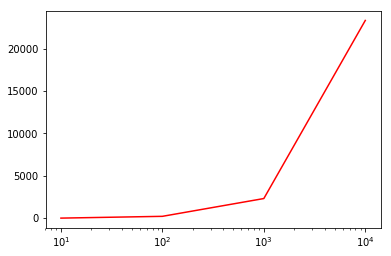

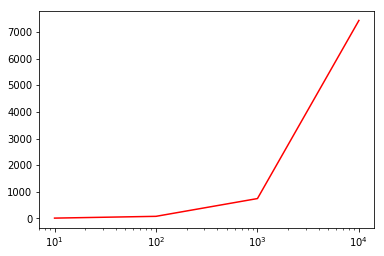

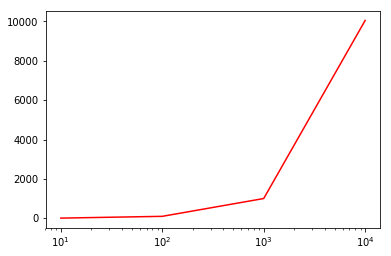

In [140]:
graph_result()

Дальше мы увеличили размер алфавита до 26 символов и повторили все действия

In [141]:
ALP_LENGTH = 26

pattern = string_generator(ALP_LENGTH, PATTERN_LENGTH)
set10 = testset_generator(ALP_LENGTH, 10)
set100 = testset_generator(ALP_LENGTH, 100)
set1000 = testset_generator(ALP_LENGTH, 1000)
set10000 = testset_generator(ALP_LENGTH, 10000)

In [142]:
test(Naive)

14 11 11.221
203 191 194.796
2050 2014 2030.882
20457 20334 20390.049


In [143]:
test(BMH)

38 34 34.115
83 70 73.333
494 449 471.335
4518 4389 4452.593


In [144]:
test(RabinKarp)

11 11 11.0
102 101 101.002
1006 1001 1001.013
10006 10001 10001.088


Результаты также представлены в виде графиков:

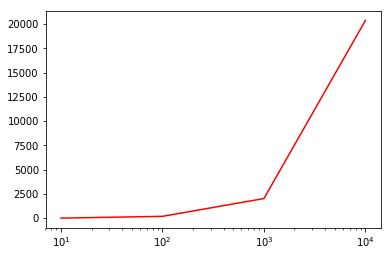

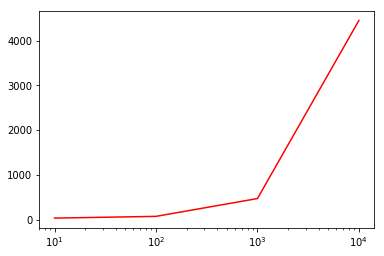

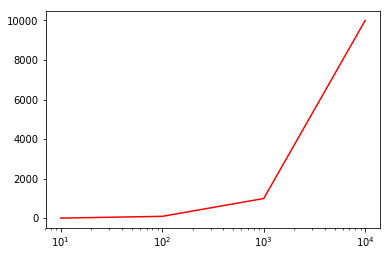

In [145]:
graph_result()

В общем, можно заметить, что количество итераций относительно длины строки зависит линейно: длина строки увеличилась в 10 раз - количество операций увеличилось примерно также.

Самые плохие результаты показывает наивный алгоритм, самые хорошие - алгоритм BMH, что не удивительно, ведь последний лучше всего оптимизирует количество сдвигов за счет эвристики "плохого символа".

По какой-то причине на алфавите бОльшего размеры алгоритмы дают более хорошие результаты.